# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=10  # 批次大，show_step就小点
max_epoch=60  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, self.one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        #w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        w=torch.randn(w.shape).cuda()*0.1
      
        out=out*w
       
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                print(x)
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

[1024, 1]


In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % show_step == 0:
            if batch_idx % 2*show_step == 0:
                print(model.layers[12].conv1D.weight.shape)
                print(model.layers[12].conv1D.weight)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
# writer = SummaryWriter()
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.332016, Accuracy: 11.33
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.326073, Accuracy: 10.55
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.212

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 1 [10240/50000 (23%)]	Loss: 1.960140, Accuracy: 20.31
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 1 [12800/50000 (28%)]	Loss: 1.940920, Accuracy: 22.27
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 2 [20480/50000 (45%)]	Loss: 1.844316, Accuracy: 24.61
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 2 [23040/50000 (51%)]	Loss: 1.730028, Accuracy: 31.64
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.639821, Accuracy: 32.03
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 3 [33280/50000 (74%)]	Loss: 1.685220, Accuracy: 32.03
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 4 [40960/50000 (91%)]	Loss: 1.471940, Accuracy: 40.23
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 4 [43520/50000 (97%)]	Loss: 1.495878, Accuracy: 43.36

Validation set: Average loss: 1.9198, Accuracy: 1669/5000 (33.00%)

the time of this epoch:[641.5705807209015 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 6 [2560/50000 (6%)]	Loss: 1.398475, Accuracy: 55.08
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 6 [5120/50000 (11%)]	Loss: 1.443082, Accuracy: 48.83
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 7 [12800/50000 (28%)]	Loss: 1.247508, Accuracy: 53.91
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 7 [15360/50000 (34%)]	Loss: 1.281556, Accuracy: 57.03
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 8 [23040/50000 (51%)]	Loss: 1.141930, Accuracy: 54.30
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 8 [25600/50000 (57%)]	Loss: 1.136956, Accuracy: 60.55
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 9 [33280/50000 (74%)]	Loss: 1.101229, Accuracy: 66.02
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 9 [35840/50000 (80%)]	Loss: 1.150982, Accuracy: 60.16
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 10 [40960/50000 (91%)]	Loss: 1.043955, Accuracy: 63.28
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 10 [43520/50000 (97%)]	Loss: 1.020824, Accuracy: 65.62

Validation set: Average loss: 1.1466, Accuracy: 2965/5000 (59.00%)

the time of this epoch:[644.6091778278351 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237,

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 12 [2560/50000 (6%)]	Loss: 0.932904, Accuracy: 68.75
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 12 [5120/50000 (11%)]	Loss: 1.012735, Accuracy: 67.97
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.936231, Accuracy: 72.27
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.961897, Accuracy: 67.97
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 14 [17920/50000 (40%)]	Loss: 0.837448, Accuracy: 74.22
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 14 [20480/50000 (45%)]	Loss: 0.915085, Accuracy: 69.92
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 15 [25600/50000 (57%)]	Loss: 0.858104, Accuracy: 74.61
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 15 [28160/50000 (62%)]	Loss: 0.823981, Accuracy: 73.83
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 16 [33280/50000 (74%)]	Loss: 0.828178, Accuracy: 74.61
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 16 [35840/50000 (80%)]	Loss: 0.953948, Accuracy: 76.17
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 17 [40960/50000 (91%)]	Loss: 0.894169, Accuracy: 75.39
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 17 [43520/50000 (97%)]	Loss: 0.675471, Accuracy: 76.17

Validation set: Average loss: 0.8121, Accuracy: 3792/5000 (75.00%)

the time of this epoch:[644.607898235321 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, 

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.777067, Accuracy: 74.61
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.857615, Accuracy: 73.83
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 20 [10240/50000 (23%)]	Loss: 0.804170, Accuracy: 74.61
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 20 [12800/50000 (28%)]	Loss: 0.894630, Accuracy: 78.12
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 21 [17920/50000 (40%)]	Loss: 0.554514, Accuracy: 85.94
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 21 [20480/50000 (45%)]	Loss: 0.778907, Accuracy: 75.39
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 22 [25600/50000 (57%)]	Loss: 0.687045, Accuracy: 77.73
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 22 [28160/50000 (62%)]	Loss: 0.686979, Accuracy: 80.08
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 23 [33280/50000 (74%)]	Loss: 0.774945, Accuracy: 78.12
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 23 [35840/50000 (80%)]	Loss: 0.580065, Accuracy: 82.42
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.643564, Accuracy: 80.47
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.673856, Accuracy: 79.69

Validation set: Average loss: 0.7141, Accuracy: 3986/5000 (79.00%)

the time of this epoch:[644.1298608779907 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237,

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.578089, Accuracy: 81.64
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.665686, Accuracy: 80.47
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 27 [10240/50000 (23%)]	Loss: 0.689122, Accuracy: 78.91
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 27 [12800/50000 (28%)]	Loss: 0.644279, Accuracy: 76.56
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 28 [17920/50000 (40%)]	Loss: 0.518930, Accuracy: 85.55
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 28 [20480/50000 (45%)]	Loss: 0.581429, Accuracy: 82.81
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.642618, Accuracy: 83.20
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.652991, Accuracy: 82.03
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 30 [33280/50000 (74%)]	Loss: 0.470232, Accuracy: 87.50
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 30 [35840/50000 (80%)]	Loss: 0.686503, Accuracy: 83.20
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.551410, Accuracy: 84.38
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 31 [43520/50000 (97%)]	Loss: 0.551929, Accuracy: 83.20

Validation set: Average loss: 0.6326, Accuracy: 4112/5000 (82.00%)

the time of this epoch:[644.3723690509796 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237,

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 33 [2560/50000 (6%)]	Loss: 0.479290, Accuracy: 86.33
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 33 [5120/50000 (11%)]	Loss: 0.516698, Accuracy: 86.72
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 34 [10240/50000 (23%)]	Loss: 0.559476, Accuracy: 85.16
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 34 [12800/50000 (28%)]	Loss: 0.547622, Accuracy: 82.03
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 35 [17920/50000 (40%)]	Loss: 0.524816, Accuracy: 85.16
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 35 [20480/50000 (45%)]	Loss: 0.417214, Accuracy: 85.94
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 36 [25600/50000 (57%)]	Loss: 0.579712, Accuracy: 85.94
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 36 [28160/50000 (62%)]	Loss: 0.655642, Accuracy: 81.25
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.492632, Accuracy: 83.59
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.580295, Accuracy: 80.86
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 38 [40960/50000 (91%)]	Loss: 0.457648, Accuracy: 86.72
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 38 [43520/50000 (97%)]	Loss: 0.387375, Accuracy: 89.84

Validation set: Average loss: 0.6233, Accuracy: 4150/5000 (83.00%)

the time of this epoch:[644.8158206939697 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237,

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.429453, Accuracy: 87.11
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 40 [5120/50000 (11%)]	Loss: 0.525432, Accuracy: 85.55
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 41 [10240/50000 (23%)]	Loss: 0.542048, Accuracy: 85.94
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 41 [12800/50000 (28%)]	Loss: 0.540344, Accuracy: 82.81
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.510851, Accuracy: 83.20
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.578338, Accuracy: 85.55
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.308953, Accuracy: 90.62
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.402510, Accuracy: 87.50
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 44 [33280/50000 (74%)]	Loss: 0.411100, Accuracy: 88.28
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 44 [35840/50000 (80%)]	Loss: 0.430612, Accuracy: 87.89
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.495156, Accuracy: 85.94
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 45 [43520/50000 (97%)]	Loss: 0.496007, Accuracy: 83.59

Validation set: Average loss: 0.5895, Accuracy: 4190/5000 (83.00%)

the time of this epoch:[644.9573245048523 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237,

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 47 [2560/50000 (6%)]	Loss: 0.488811, Accuracy: 84.77
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 47 [5120/50000 (11%)]	Loss: 0.460457, Accuracy: 89.45
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 48 [10240/50000 (23%)]	Loss: 0.498905, Accuracy: 85.94
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 48 [12800/50000 (28%)]	Loss: 0.447954, Accuracy: 88.28
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.397882, Accuracy: 87.50
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.427625, Accuracy: 87.11
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 50 [25600/50000 (57%)]	Loss: 0.516385, Accuracy: 85.55
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 50 [28160/50000 (62%)]	Loss: 0.369054, Accuracy: 89.45
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 51 [33280/50000 (74%)]	Loss: 0.541610, Accuracy: 86.72
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 51 [35840/50000 (80%)]	Loss: 0.415431, Accuracy: 85.94
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 52 [40960/50000 (91%)]	Loss: 0.395535, Accuracy: 88.28
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 52 [43520/50000 (97%)]	Loss: 0.492148, Accuracy: 85.55

Validation set: Average loss: 0.6016, Accuracy: 4232/5000 (84.00%)

the time of this epoch:[645.056667804718 s]
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, 

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 54 [2560/50000 (6%)]	Loss: 0.343263, Accuracy: 89.45
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 54 [5120/50000 (11%)]	Loss: 0.450457, Accuracy: 87.50
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.380652, Accuracy: 89.45
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.449935, Accuracy: 85.16
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.321531, Accuracy: 92.97
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.350674, Accuracy: 91.02
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 57 [25600/50000 (57%)]	Loss: 0.374924, Accuracy: 91.02
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 57 [28160/50000 (62%)]	Loss: 0.485631, Accuracy: 88.28
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.360126, Accuracy: 91.02
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.332035, Accuracy: 89.84
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

       

torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 59 [40960/50000 (91%)]	Loss: 0.402484, Accuracy: 88.28
torch.Size([1024, 1, 3])
Parameter containing:
tensor([[[-0.0806, -0.1844, -0.0295]],

        [[-0.2645,  0.4237, -0.1196]],

        [[ 0.3433, -0.1657,  0.4654]],

        ...,

        [[ 0.3166, -0.0385, -0.0085]],

        [[ 0.2122, -0.0582,  0.2063]],

        [[-0.4135,  0.2101,  0.2869]]], device='cuda:0')
Train Epoch: 59 [43520/50000 (97%)]	Loss: 0.396361, Accuracy: 88.28

Validation set: Average loss: 0.5984, Accuracy: 4213/5000 (84.00%)

the time of this epoch:[644.6210441589355 s]

Test set: Average loss: 0.6783, Accuracy: 8367/10000 (83.67%)



# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.4947, Accuracy: 8849/10000 (88.49%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

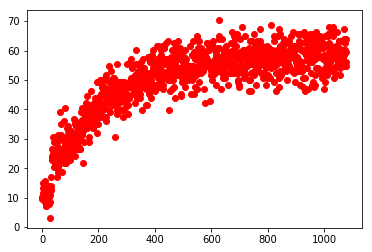

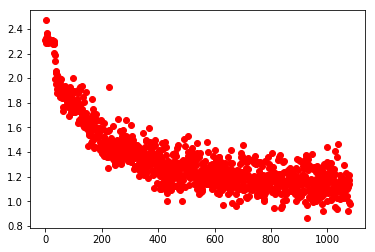

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

In [ ]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    #parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()